In [18]:
import numpy as np
import pandas as pd
from keras.datasets import mnist
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import accuracy_score

In [27]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sb


def confusion_matrix_visualisation(y, pred):
    cm = confusion_matrix(y, pred, normalize = 'true')
    fig, ax = plt.subplots(figsize = (10,8))
    sb.heatmap(cm, annot = True, cmap = 'GnBu', fmt = '.1%', ax = ax, vmin = 0, vmax = 1)
    ax.set_xlabel('prediction')
    ax.set_ylabel('label')

In [28]:
def infer_cluster_labels(kmeans, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    """

    inferred_labels = {}

    # Loop through the clusters
    for i in range(kmeans.n_clusters):

        # find index of points in cluster
        labels = []
        index = np.where(kmeans.labels_ == i)

        # append actual labels for each point in cluster
        labels.append(actual_labels[index])

        # determine most common label
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]

    return inferred_labels

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

def infer_data_labels(X_labels, cluster_labels):
    """
    Determines label for each array, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """

    # empty array of len(X)
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)

    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key

    return predicted_labels

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

from sklearn.metrics import homogeneity_score

def calc_metrics(estimator, data, labels):
    print('Number of Clusters: {}'.format(estimator.n_clusters))
    # Inertia
    inertia = estimator.inertia_
    print("Inertia: {}".format(inertia))
    # Homogeneity Score
    homogeneity = homogeneity_score(labels, estimator.labels_)
    print("Homogeneity score: {}".format(homogeneity))
    
    return inertia, homogeneity

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#printing the shapes of the vectors
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(y_test.shape))

11490434/11490434 [==============================] - 0s 0us/step
X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


In [4]:
num_samples, width, height = X_train.shape
X_train = X_train.reshape(num_samples, width * height)

num_samples, width, height = X_test.shape
X_test = X_test.reshape(num_samples, width * height)

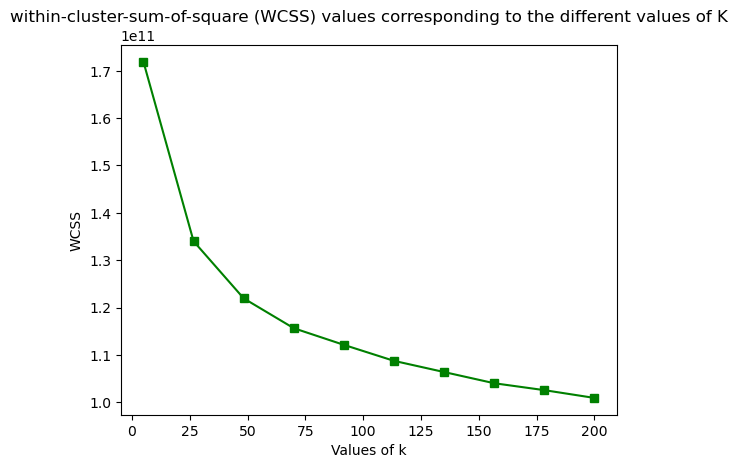

In [8]:
wcss = {}

for i in np.linspace(5,200,10):
    
	kmeans = MiniBatchKMeans(n_clusters = int(i), n_init='auto')
	kmeans.fit(X_train)
	wcss[i] = kmeans.inertia_

plt.plot(wcss.keys(), wcss.values(), 'gs-')
plt.title('within-cluster-sum-of-square (WCSS) values corresponding to the different values of K')
plt.xlabel("Values of k")
plt.ylabel('WCSS')
plt.show()

In [11]:
n_clusters = 50

kmeans = MiniBatchKMeans(n_clusters=n_clusters, n_init='auto', )
kmeans.fit(X_train)

MiniBatchKMeans(n_clusters=50, n_init='auto')

In [12]:
cluster_labels = infer_cluster_labels(kmeans, y_train)
X_clusters = kmeans.predict(X_train)
predicted_labels = infer_data_labels(X_clusters, cluster_labels)
print(predicted_labels[:20])
print(y_train[:20])

[5 0 9 1 4 2 1 3 1 4 3 5 3 6 1 7 2 8 6 7]
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]


In [21]:
inertia, homo = calc_metrics(kmeans, X_train, y_train)

# print('inertia:' , inertia , '\n' , 'homogeneity:' , homo)

# Determine predicted labels
cluster_labels = infer_cluster_labels(kmeans, y_train)
prediction = infer_data_labels(kmeans.labels_, cluster_labels)

acc = accuracy_score(y_train, prediction)
print('Accuracy on train dataset: {}\n'.format(acc))

Number of Clusters: 50
Inertia: 121377699543.85278
Homogeneity score: 0.7246582552835856
Accuracy on train dataset: 0.8085333333333333



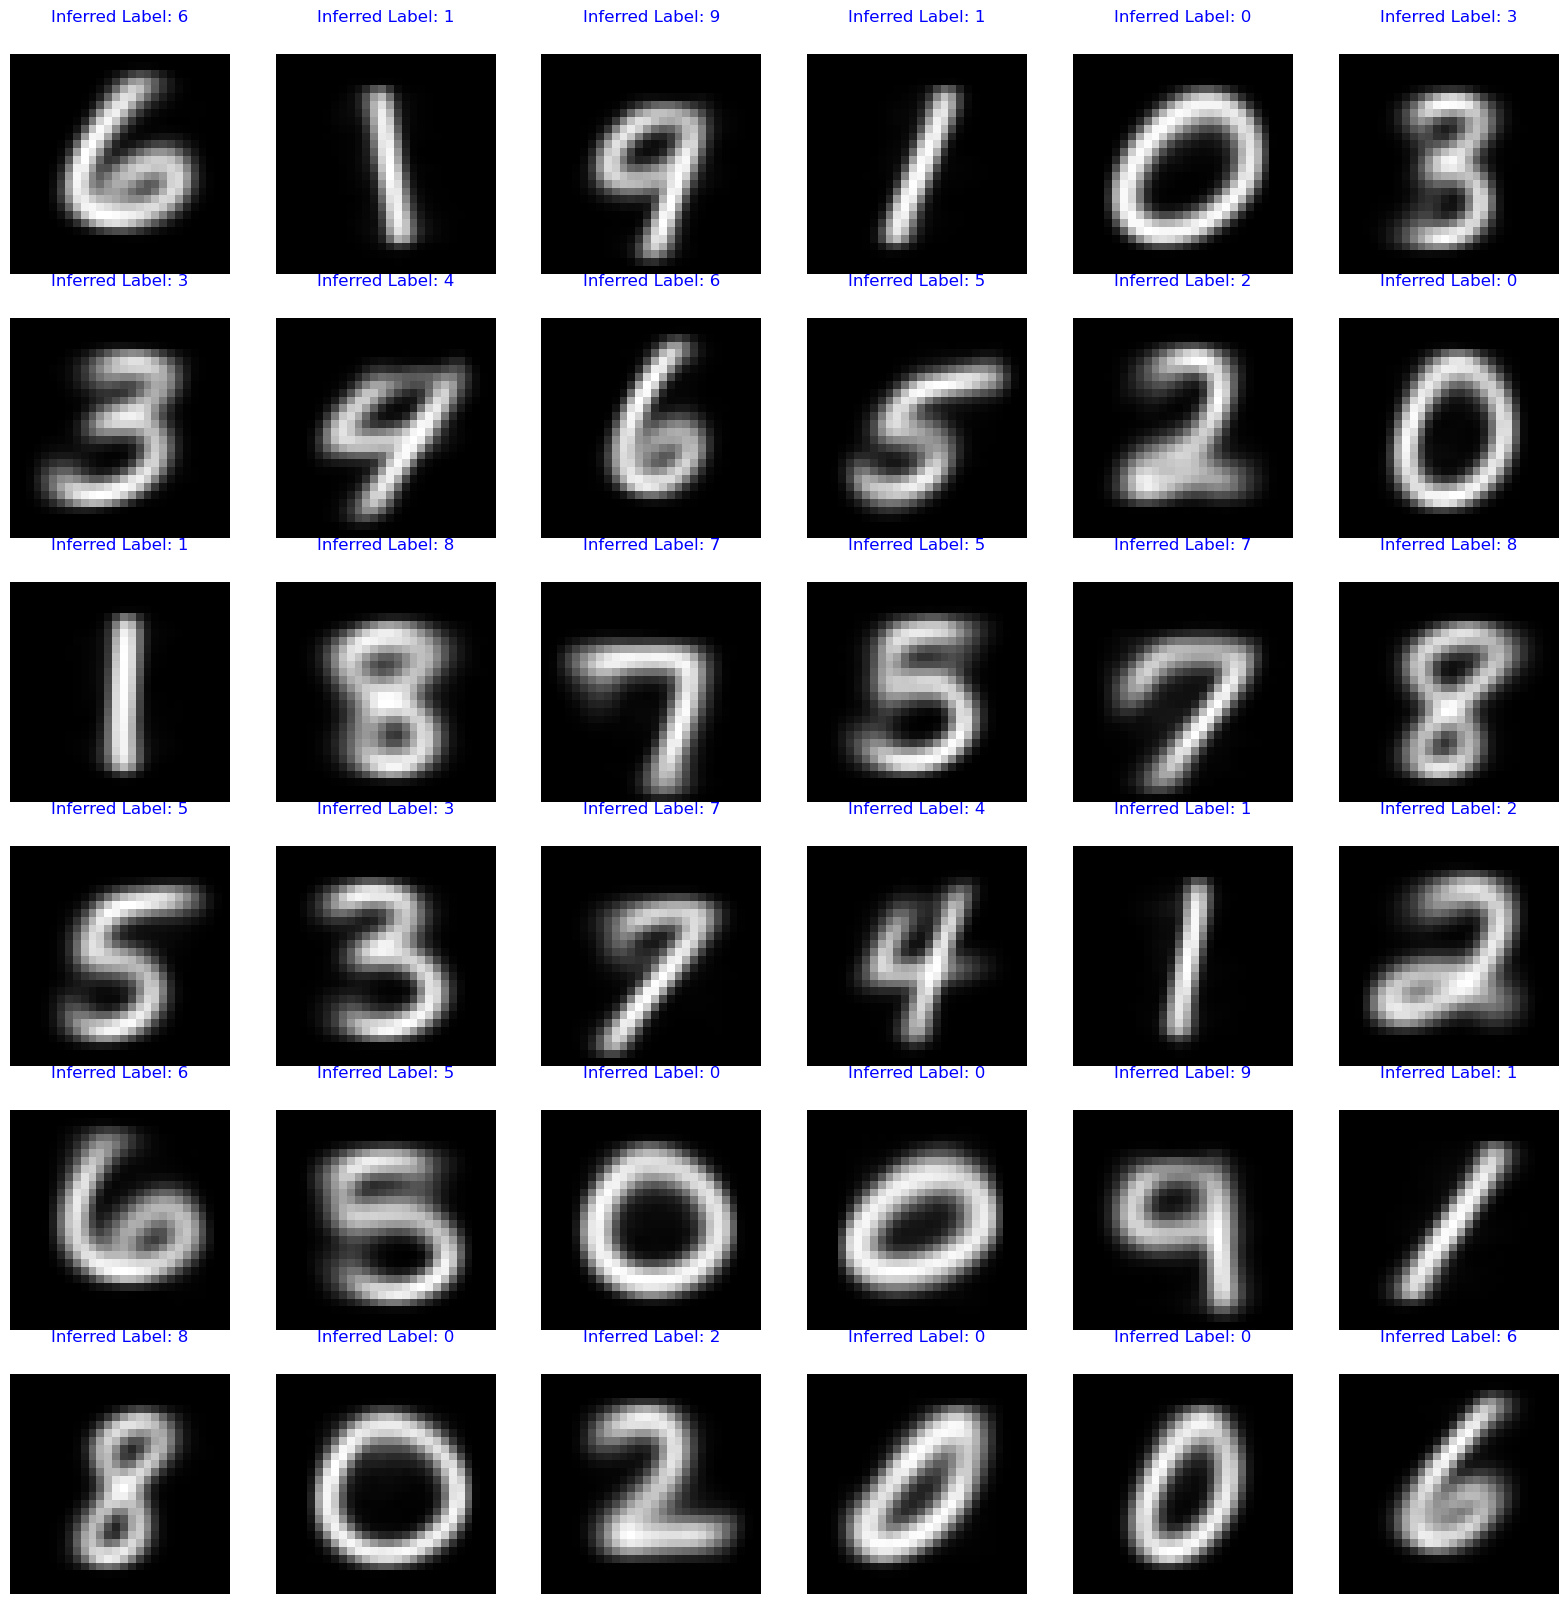

In [37]:
n_clusters = 50

# record centroid values
centroids = kmeans.cluster_centers_

# reshape centroids into images
images = centroids.reshape(n_clusters, width, height)
images = images.astype(np.uint8)


# create figure with subplots using matplotlib.pyplot
fig, axs = plt.subplots(6, 6, figsize = (20, 20))
plt.gray()

# loop through subplots and add centroid images
for i, ax in enumerate(axs.flat):

    # determine inferred label using cluster_labels dictionary
    for key, value in cluster_labels.items():
        if i in value:
            ax.set_title('Inferred Label: {}'.format(key), color='blue')

    # add image to subplot
    ax.matshow(images[i])
    ax.axis('off')

# display the figure
plt.show()

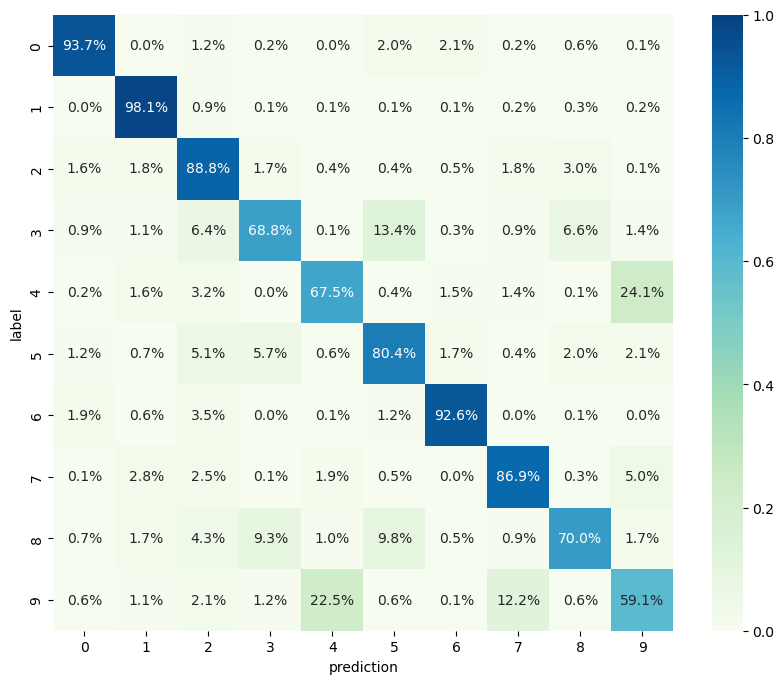

In [38]:
cm = confusion_matrix_visualisation(y_train, prediction)

In [54]:
X_clusters = kmeans.predict(X_test)

prediction_test = infer_data_labels(X_clusters, cluster_labels)

acc = accuracy_score(y_test, prediction_test)
print('Accuracy on test dataset: {}\n'.format(acc))

Accuracy on test dataset: 0.8165



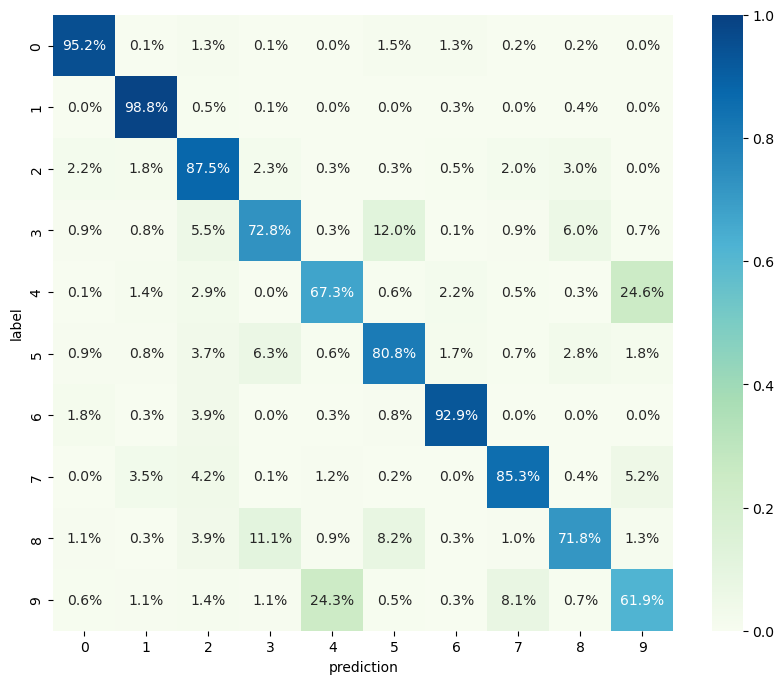

In [55]:
cm = confusion_matrix_visualisation(y_test, prediction)

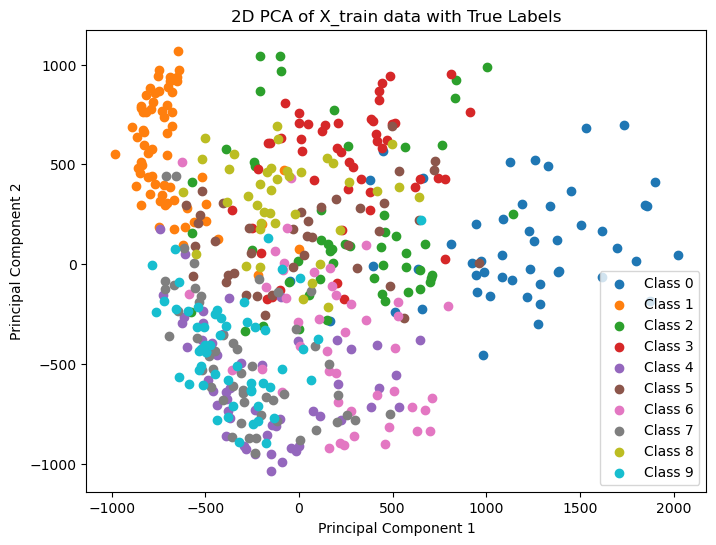

In [64]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X_train_samples = X_train[:500]
y_train_samples = y_train[:500]

# Assuming X_train is the feature matrix and y_train is the target labels
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_samples)

# Create a scatter plot with different colors for different labels
plt.figure(figsize=(8, 6))
for label in np.unique(y_train_samples):
    plt.scatter(X_pca[y_train_samples == label, 0], X_pca[y_train_samples == label, 1], label=f'Class {label}')

plt.title('2D PCA of X_train data with True Labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()
